Starting analysis with 3000 samples...

--- 2D Analysis ---

Creating plots for 2D Normal and Mixed Normals...


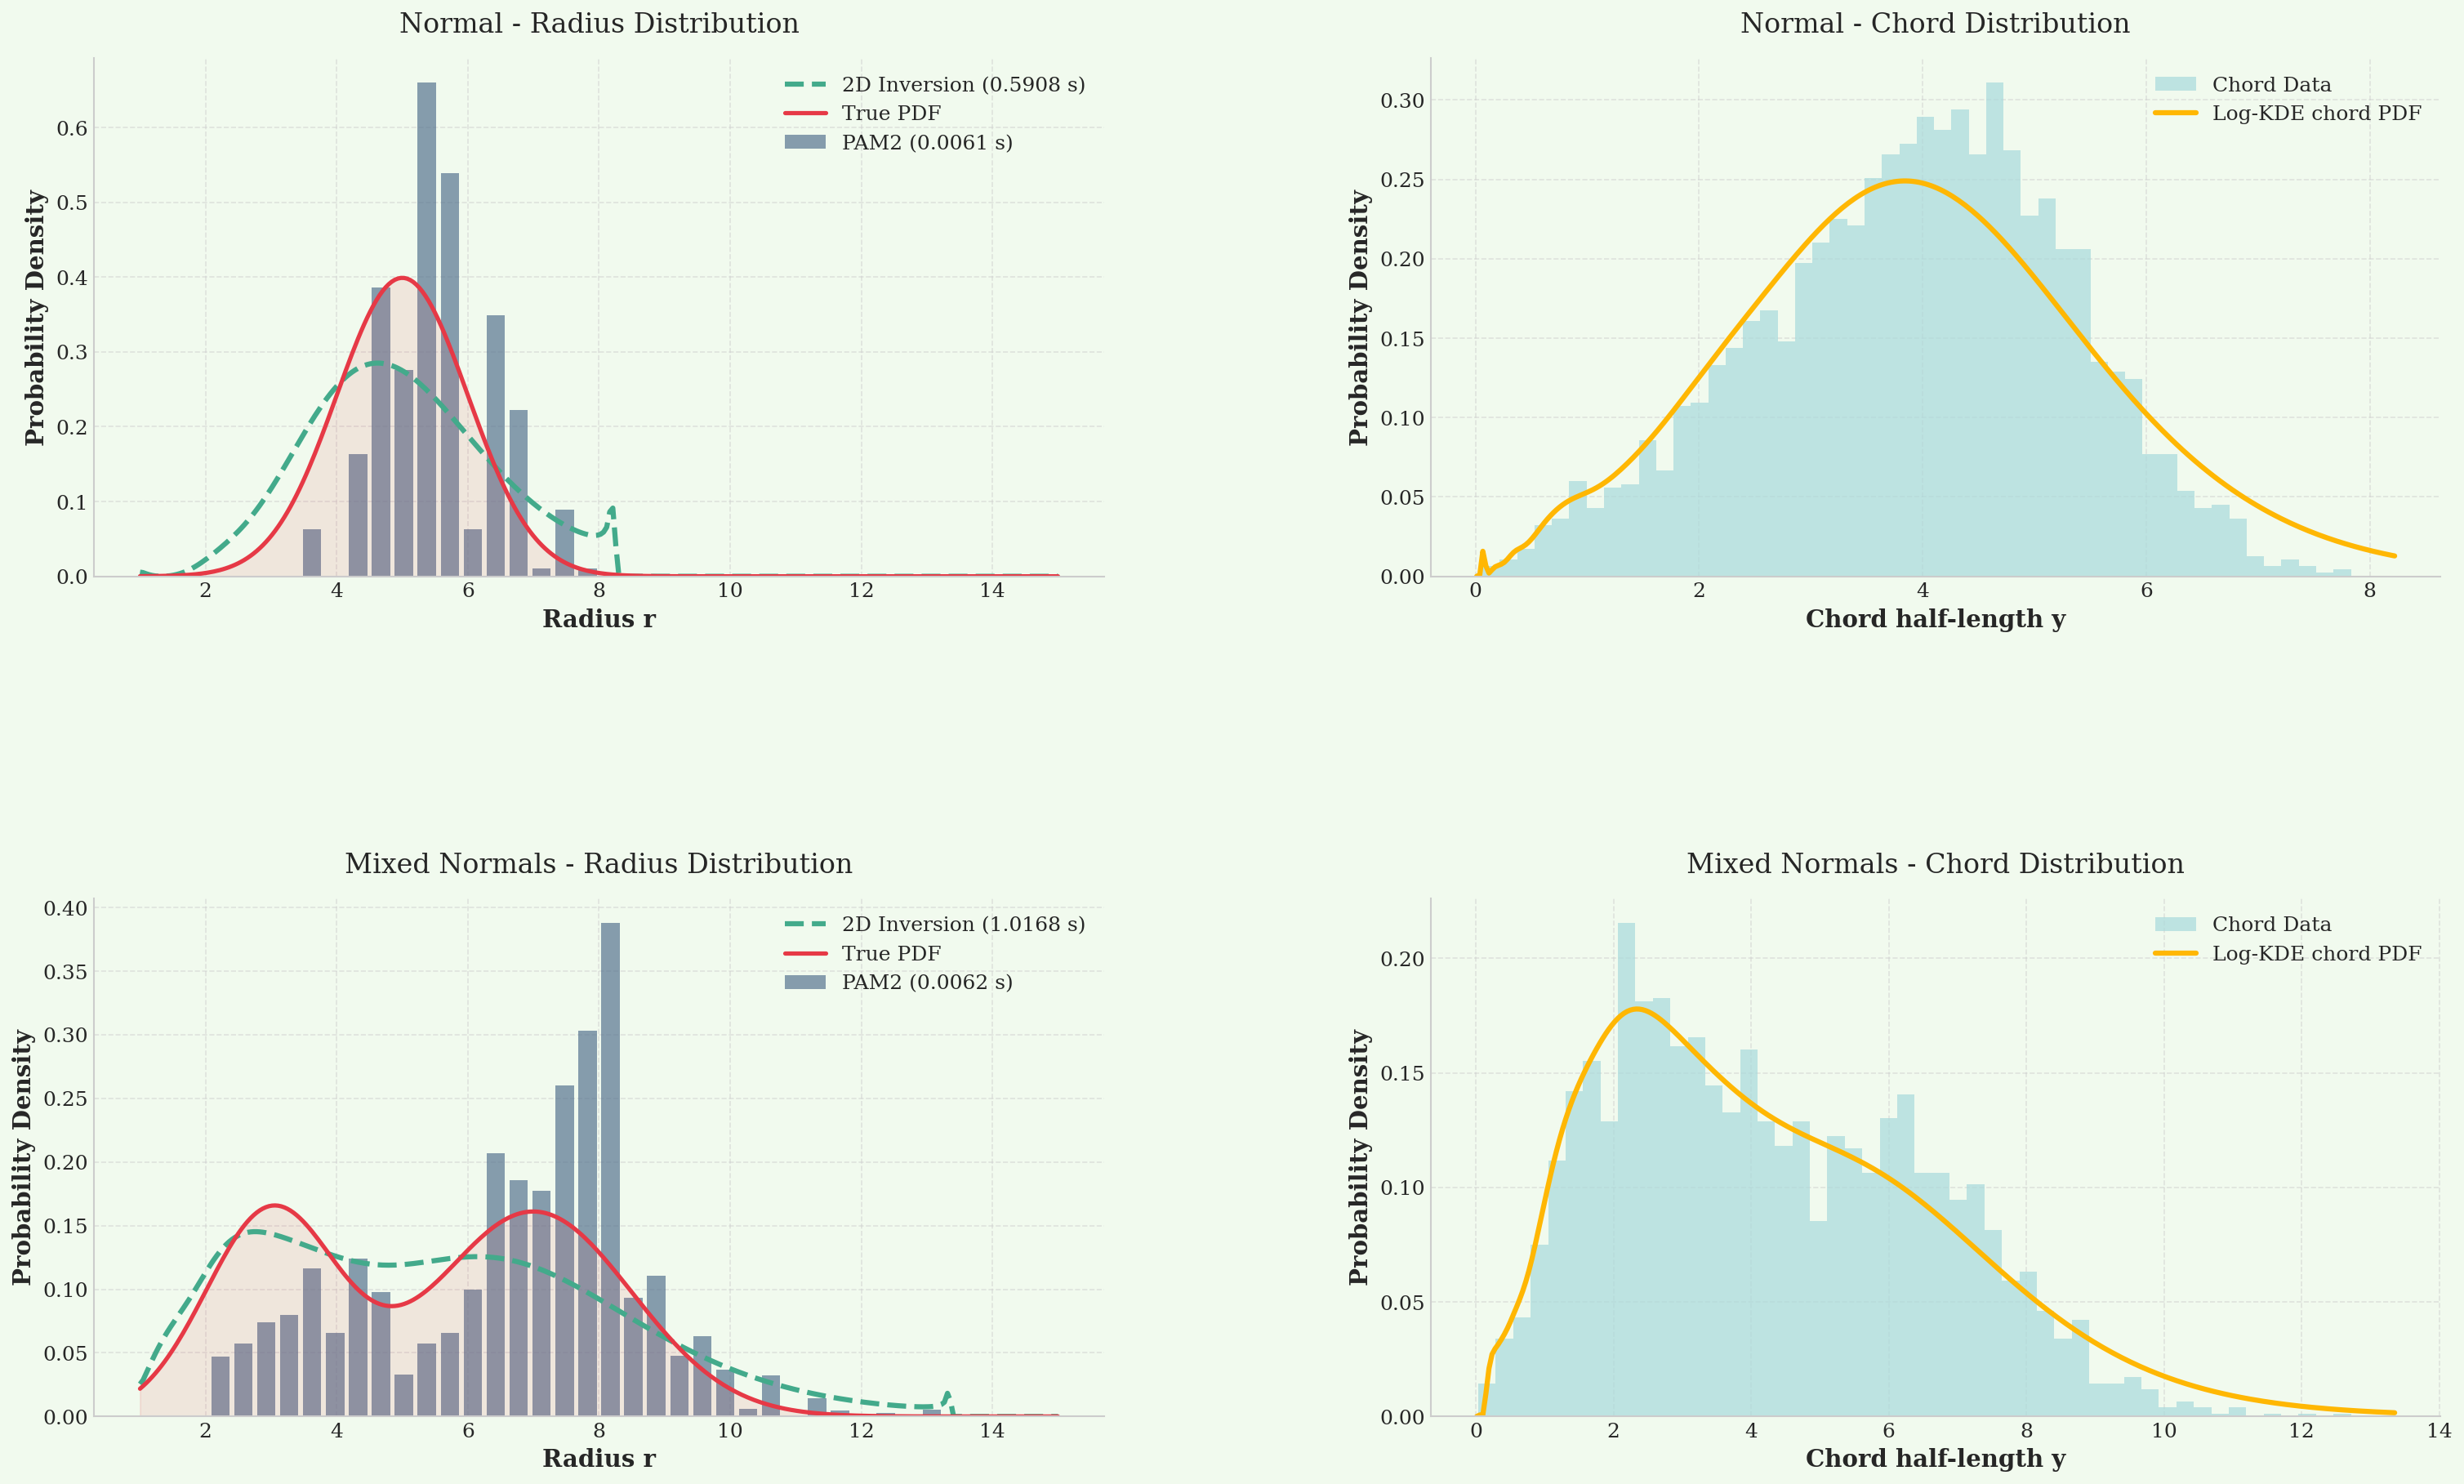

Creating plots for 2D Lognormal and Gamma...


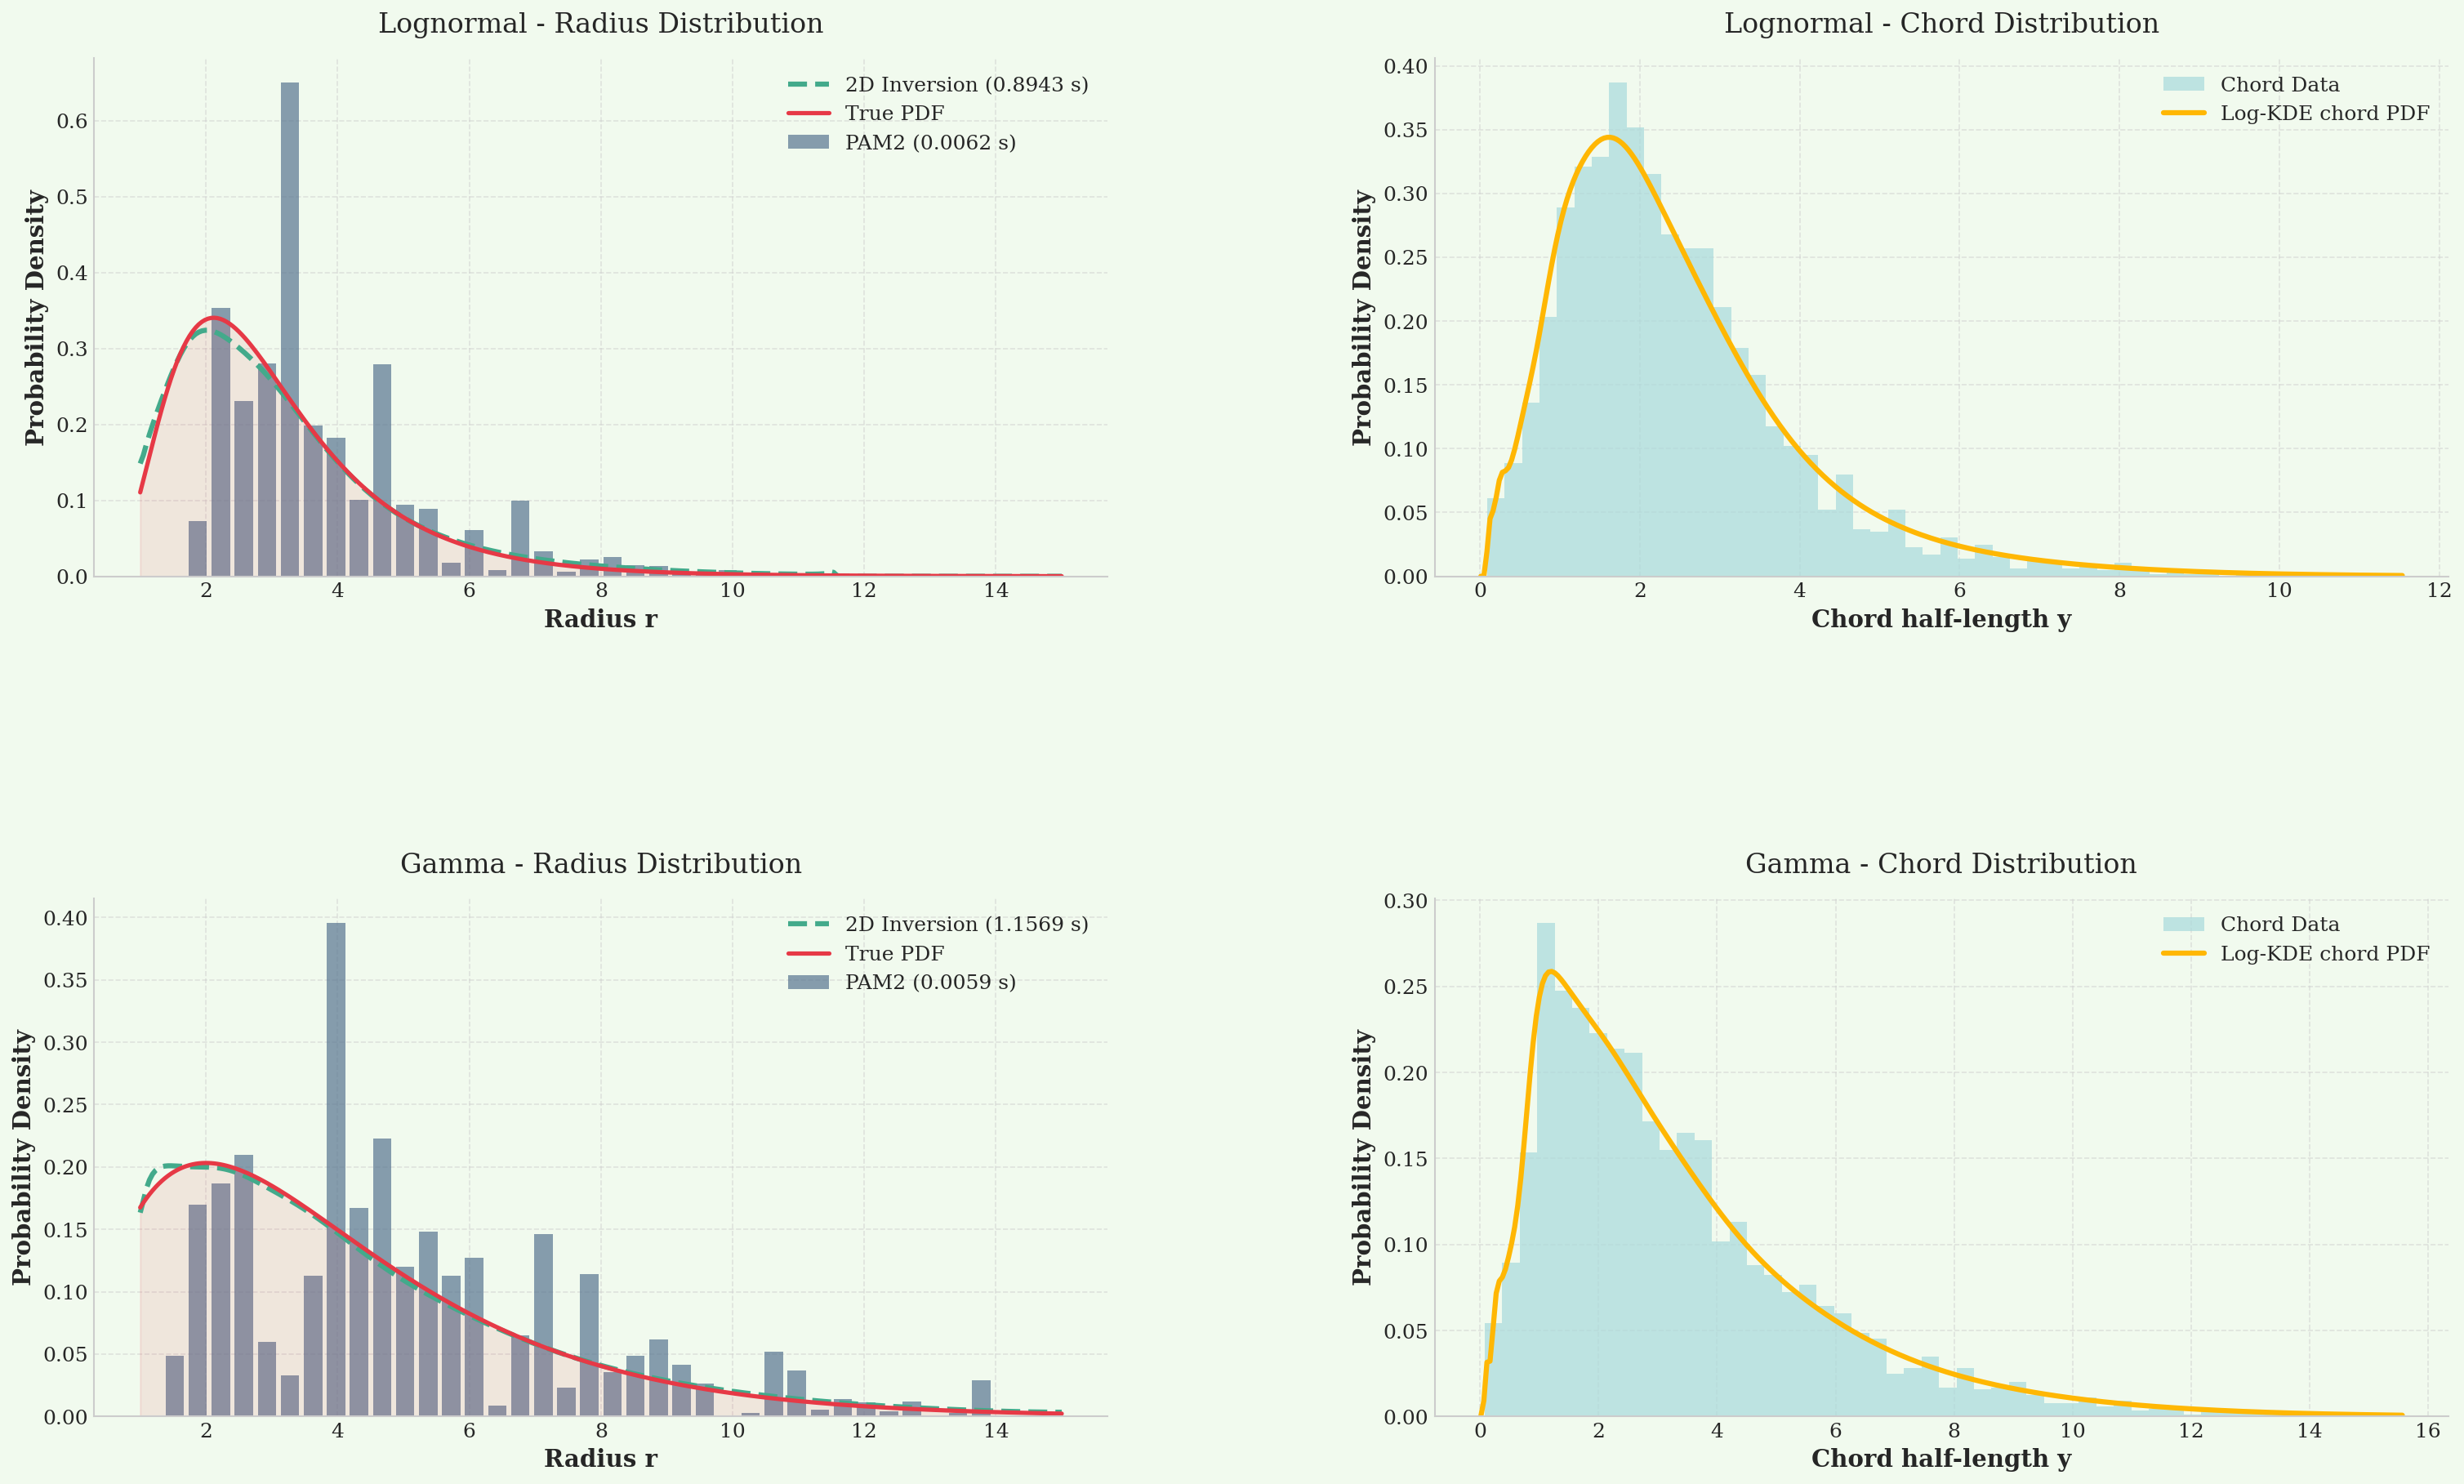


--- Performance Comparison ---
Distribution         Direct Inversion (s)      PAM2 (s)                 
----------------------------------------------------------------------
Normal               0.5908                    0.0061                   
Mixed Normals        1.0168                    0.0062                   
Lognormal            0.8943                    0.0062                   
Gamma                1.1569                    0.0059                   


--- 3D Analysis ---

Creating plots for 3D Normal and Mixed Normals...


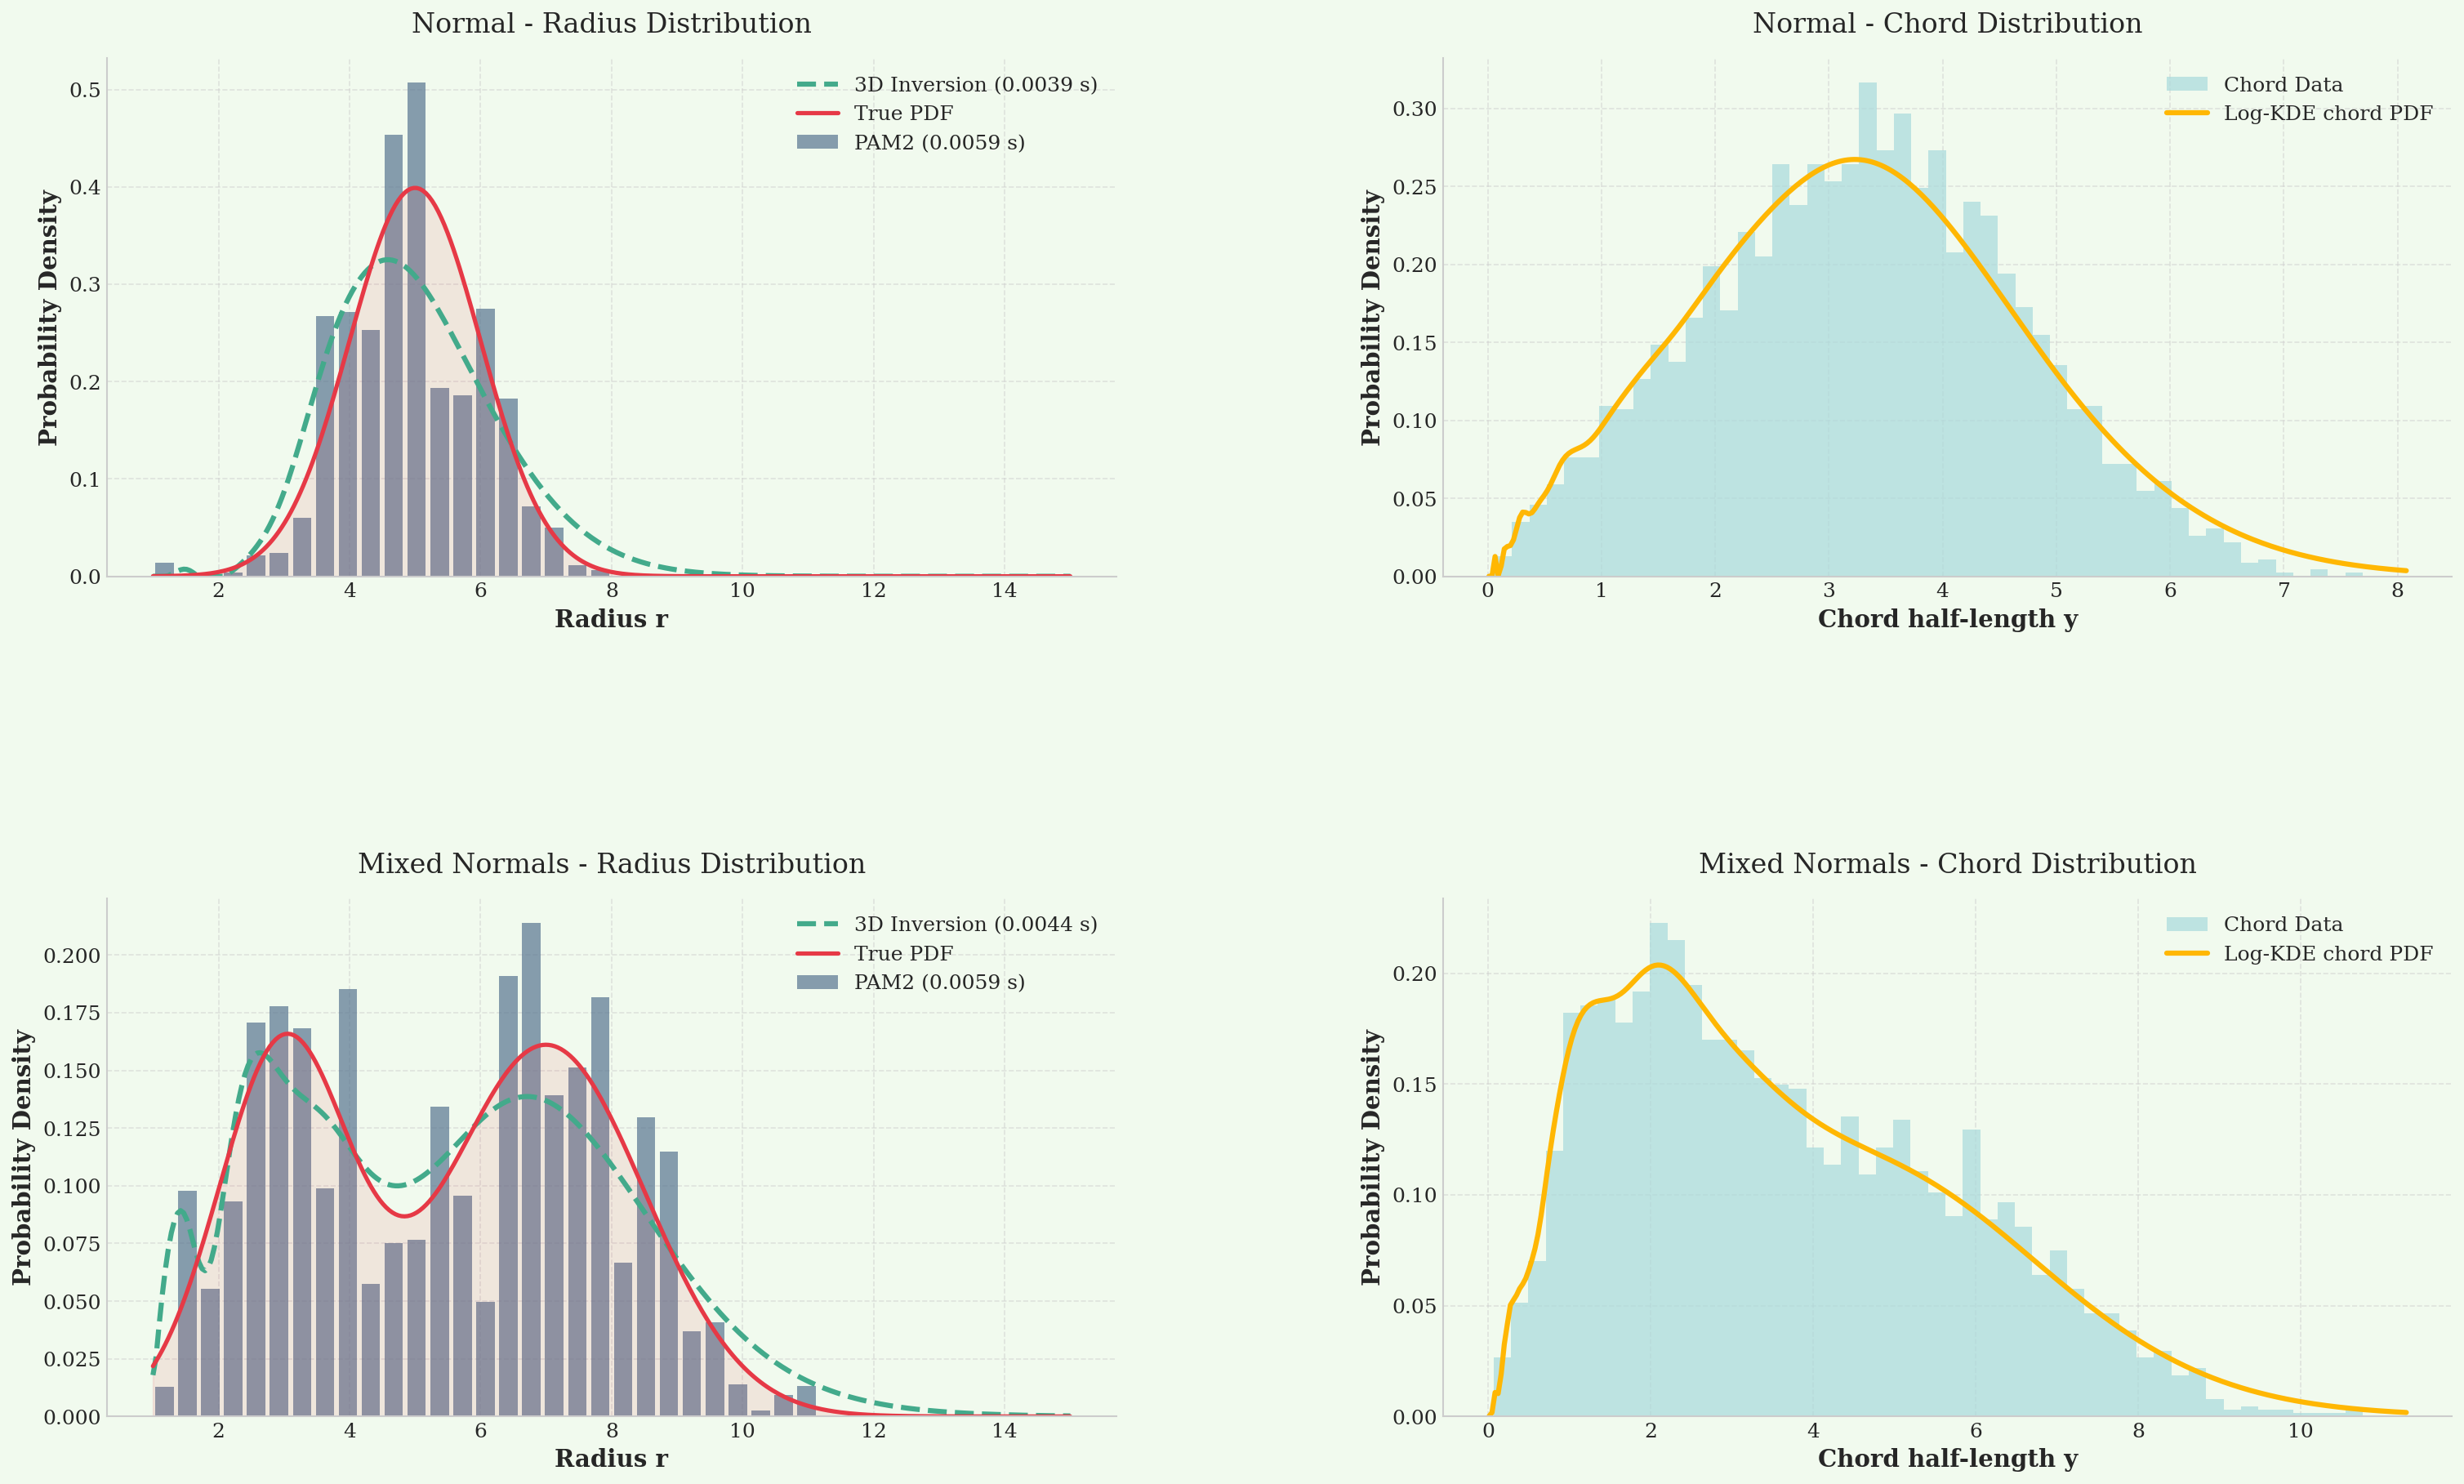

Creating plots for 3D Lognormal and Gamma...


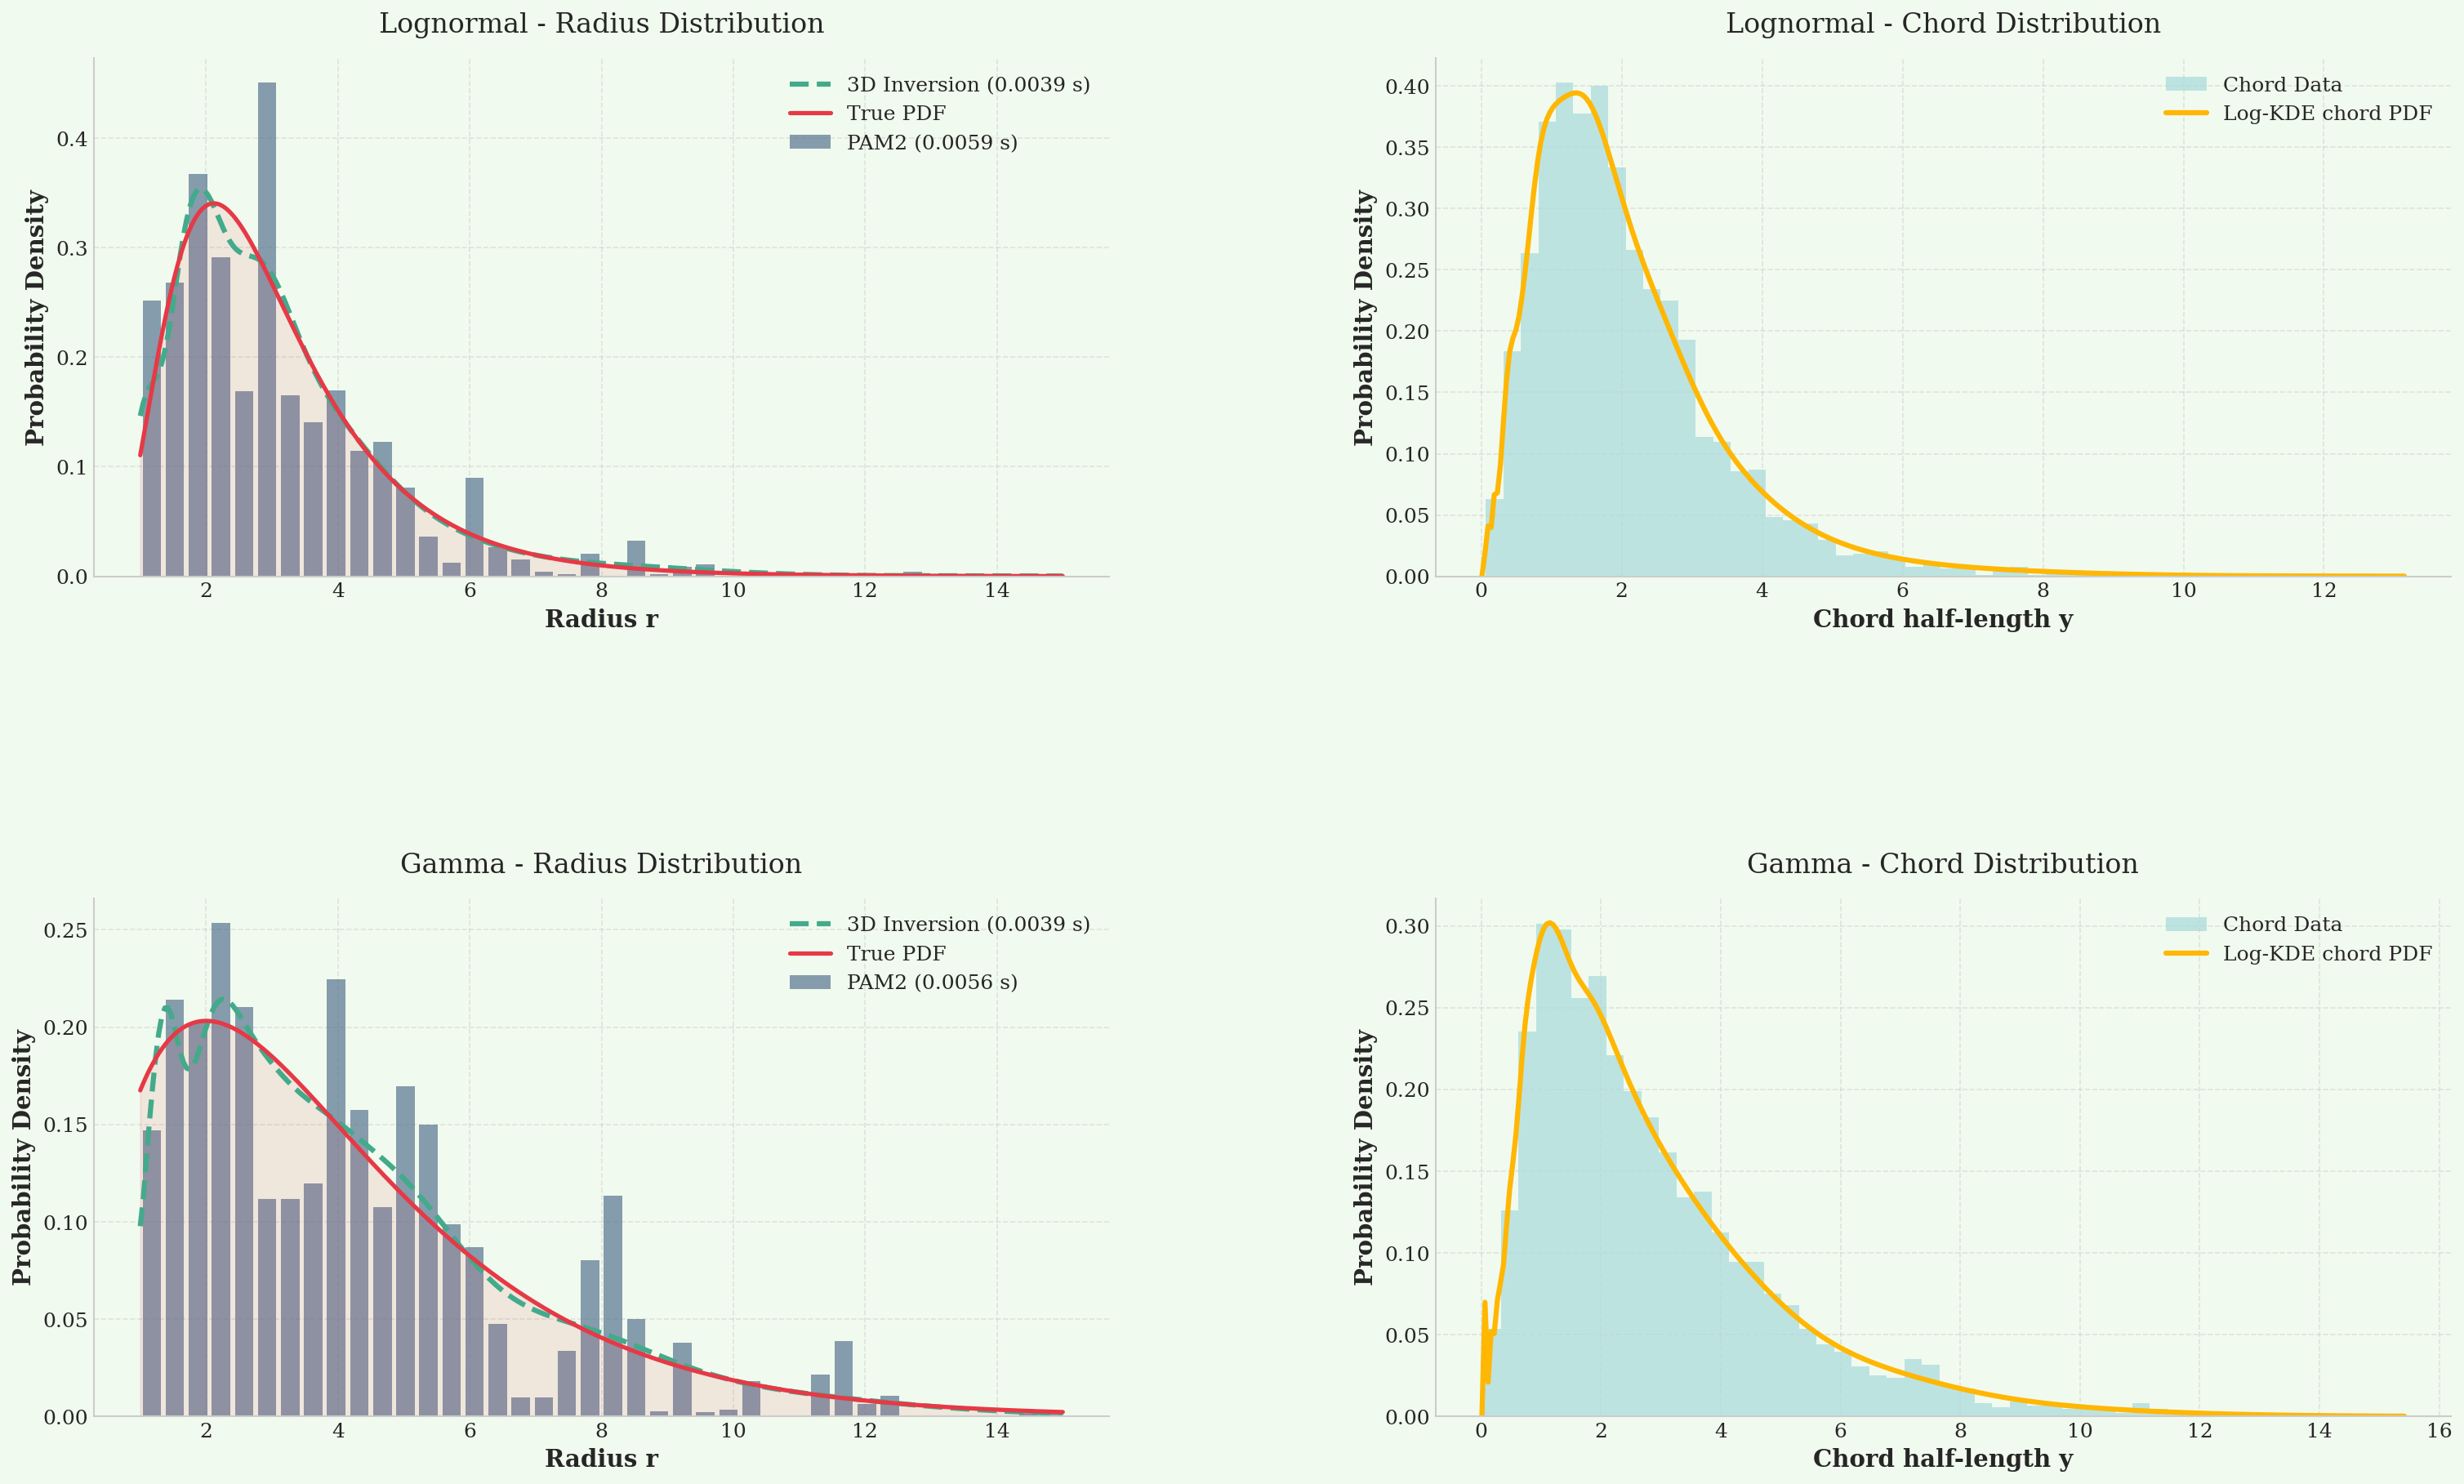


--- Performance Comparison ---
Distribution         Direct Inversion (s)      PAM2 (s)                 
----------------------------------------------------------------------
Normal               0.0039                    0.0059                   
Mixed Normals        0.0044                    0.0059                   
Lognormal            0.0039                    0.0059                   
Gamma                0.0039                    0.0056                   




In [1]:
# ==============================================================================
# Step 1: Import Libraries and Set Configuration
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
from scipy.special import gamma
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import time

# Configure plot settings for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "figure.dpi": 150,
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "grid.alpha": 0.4,
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.figsize": (16, 10),
})

# Configuration parameters
NUM_SAMPLES = 3000
RANDOM_SEED = 123

# ==============================================================================
# Step 2: Define Probability Distributions
# ==============================================================================
def pdf_truncated_normal(r, mu=5.0, sigma=1.0):
    if r < 1: return 0.0
    return (1.0/(sigma*sqrt(2*pi))) * np.exp(-0.5*((r - mu)/sigma)**2)

def pdf_lognormal(r, logmean=1.0, logstd=0.5):
    if r < 1: return 0.0
    return (1.0/(r*logstd*np.sqrt(2*pi))) * np.exp(-(np.log(r)-logmean)**2 / (2*(logstd**2)))

def pdf_gamma(r, shape=2.0, scale=2.0):
    if r < 1: return 0.0
    return (1.0/(gamma(shape)*(scale**shape))) * (r**(shape-1))* np.exp(-r/scale)

def pdf_mixture_of_normals(r, weights=[0.4,0.6], mus=[3.0,7.0], sigmas=[1.0,1.5]):
    if r < 1: return 0.0
    val = 0.0
    for w,m,s in zip(weights,mus,sigmas):
        val += w*(1.0/(s*sqrt(2*pi))) * np.exp(-0.5*(((r - m)/s)**2))
    return val

# ==============================================================================
# Step 3: Sampling Radii and Chords
# ==============================================================================
def sample_radius(pdf_func, N=3000, r_min=1.0, r_max=15.0, rng=None):
    if rng is None: rng = np.random.default_rng()
    r_test = np.linspace(r_min, r_max, 300)
    pdf_vals = np.array([pdf_func(rr) for rr in r_test])
    pdf_max = pdf_vals.max() if len(pdf_vals) > 0 else 1.0
    samples = []
    while len(samples) < N:
        rp = rng.uniform(r_min, r_max)
        yp = rng.uniform(0, pdf_max)
        if yp <= pdf_func(rp):
            samples.append(rp)
    return np.array(samples)

def sample_chords_2D(radii, rng=None):
    if rng is None: rng = np.random.default_rng()
    xvals = rng.random(len(radii)) * radii
    return np.sqrt(radii**2 - xvals**2)

def sample_chords_3D(radii, rng=None):
    if rng is None: rng = np.random.default_rng()
    u = rng.random(len(radii))
    rho = radii * np.sqrt(u)
    return np.sqrt(radii**2 - rho**2)

# ==============================================================================
# Step 4: Log-Space Kernel Density Estimation (KDE)
# ==============================================================================
def gaussian_kernel(z):
    return (1.0/np.sqrt(2.0*pi))*np.exp(-0.5*z**2)

class LogSpaceKDE:
    def __init__(self, chord_data, bandwidth=0.2):
        self.log_data = np.log(chord_data[chord_data > 0])
        self.N = len(self.log_data)
        self.bandwidth = bandwidth

    def p_l(self, ell):
        ell = np.atleast_1d(ell)
        vals = np.zeros_like(ell, dtype=float)
        for i, e in enumerate(ell):
            z = (e - self.log_data) / self.bandwidth
            vals[i] = np.sum(gaussian_kernel(z))
        return vals / (self.N * self.bandwidth)

    def p_c(self, y):
        y = np.atleast_1d(y)
        vals = np.zeros_like(y, dtype=float)
        valid = (y > 0)
        ell = np.log(y[valid])
        p_l_vals = self.p_l(ell)
        vals[valid] = p_l_vals / y[valid]
        return vals

# ==============================================================================
# Step 5: Direct Inversion Formulas
# ==============================================================================
def direct_inversion_2D(chord_kde, r_grid, y_max=None, num_y=300):
    if y_max is None: y_max = r_grid[-1] * 1.05
    def G(r):
        if r >= y_max: return 0.0
        yv = np.linspace(r, y_max, num_y)
        pc_vals = chord_kde.p_c(yv)
        integrand = np.zeros_like(yv)
        valid = yv > r
        denom = np.sqrt(1.0 - (r/yv[valid])**2)
        integrand[valid] = (1.0/denom)*(pc_vals[valid]/yv[valid])
        return np.trapz(integrand, yv)

    G_vals = np.array([G(rr) for rr in r_grid])
    dG = np.gradient(G_vals, r_grid)
    p_r_vals = -(2*r_grid/pi) * dG
    p_r_vals[p_r_vals < 0] = 0.0
    area = np.trapz(p_r_vals, r_grid)
    if area > 0: p_r_vals /= area
    return p_r_vals

def direct_inversion_3D(chord_data, r_grid, bandwidth=0.15):
    chord_kde = LogSpaceKDE(chord_data, bandwidth=bandwidth)
    pc_vals = chord_kde.p_c(r_grid)
    g_vals = np.zeros_like(r_grid)
    mask = r_grid > 0
    g_vals[mask] = pc_vals[mask]/r_grid[mask]
    dg = np.gradient(g_vals, r_grid)
    p_r = -0.5 * (r_grid**2) * dg
    p_r[p_r < 0] = 0.0
    area = np.trapz(p_r, r_grid)
    if area > 0: p_r /= area
    return p_r

# ==============================================================================
# Step 6: PAM2 Algorithm
# ==============================================================================
def chord_pdf_given_r_2D(y, r):
    if not (0 < y < r): return 0.0
    denom = np.sqrt(1.0 - (y/r)**2)
    return 1.0 / (pi * r * denom)

def chord_pdf_given_r_3D(y, r):
    if not (0 < y <= r): return 0.0
    return y / (r**2)

def construct_T_matrix(radius_bin_edges, chord_bin_edges, dimension):
    r_centers = 0.5 * (radius_bin_edges[:-1] + radius_bin_edges[1:])
    y_centers = 0.5 * (chord_bin_edges[:-1] + chord_bin_edges[1:])
    widths = chord_bin_edges[1:] - chord_bin_edges[:-1]
    N, M = len(r_centers), len(y_centers)
    T = np.zeros((N, M))
    pdf_func = chord_pdf_given_r_2D if dimension == "2D" else chord_pdf_given_r_3D
    for i, r_ in enumerate(r_centers):
        row_vals = np.array([pdf_func(y_, r_) * widths[j] for j, y_ in enumerate(y_centers)])
        s = np.sum(row_vals)
        if s > 0: T[i,:] = row_vals / s
    return T, r_centers

def run_pam2(T, chord_bin_counts, max_iter=80, tol=1e-7):
    N, M = T.shape
    total_chords = np.sum(chord_bin_counts)
    if total_chords == 0: return np.ones(N)/N
    p_r = np.ones(N)/N
    for _ in range(max_iter):
        p_r_old = p_r
        denom = T.T @ p_r
        p_r_new = np.zeros(N)
        for j in range(M):
            if denom[j] > 0:
                p_r_new += chord_bin_counts[j] * (T[:, j] * p_r) / denom[j]
        p_r_new /= total_chords
        if np.linalg.norm(p_r_new - p_r_old, 1) < tol: break
        p_r = p_r_new
    if p_r.sum() > 0: p_r /= p_r.sum()
    return p_r

# ==============================================================================
# Step 7: Visualization Function
# ==============================================================================
COLORS = {
    'true_pdf': '#E63946', 'inversion': '#43AA8B', 'pam2': '#577590',
    'hist': '#A8DADC', 'kde': '#FFB703', 'background': '#F1FAEE'
}

def plot_combined_results(results1, results2, dimension_label):
    fig = plt.figure(figsize=(20, 12), constrained_layout=True)
    gs = GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.3)
    fig.patch.set_facecolor(COLORS['background'])

    for i, results in enumerate([results1, results2]):
        pdf_name, r_grid, pdf_true, p_r_inv, r_centers, p_r_pam2, chords, chord_kde, time_inv, time_pam2 = results
        dr = r_centers[1] - r_centers[0] if len(r_centers) > 1 else 0.1
        pdf_bars = p_r_pam2 / dr

        # Radius Distribution Plot
        ax_r = fig.add_subplot(gs[i, 0])
        ax_r.set_facecolor(COLORS['background'])
        ax_r.bar(r_centers, pdf_bars, width=dr*0.8, alpha=0.7, color=COLORS['pam2'], label=f"PAM2 ({time_pam2:.4f} s)")
        ax_r.plot(r_grid, p_r_inv, '--', color=COLORS['inversion'], lw=3, label=f"{dimension_label} Inversion ({time_inv:.4f} s)")
        ax_r.plot(r_grid, pdf_true, '-', color=COLORS['true_pdf'], lw=2.5, label="True PDF")
        ax_r.fill_between(r_grid, 0, pdf_true, color=COLORS['true_pdf'], alpha=0.1)
        ax_r.set_xlabel("Radius r", fontweight='bold')
        ax_r.set_ylabel("Probability Density", fontweight='bold')
        ax_r.set_title(f"{pdf_name} - Radius Distribution", fontsize=16, pad=15)
        ax_r.legend()
        ax_r.grid(True, linestyle='--', alpha=0.5)

        # Chord Distribution Plot
        ax_c = fig.add_subplot(gs[i, 1])
        ax_c.set_facecolor(COLORS['background'])
        ax_c.hist(chords, bins=50, density=True, alpha=0.7, color=COLORS['hist'], label="Chord Data")
        ygrid = np.linspace(0.01, chords.max()*1.05, 300)
        pc_est = chord_kde.p_c(ygrid)
        ax_c.plot(ygrid, pc_est, '-', color=COLORS['kde'], lw=3, label="Log-KDE chord PDF")
        ax_c.set_xlabel("Chord half-length y", fontweight='bold')
        ax_c.set_ylabel("Probability Density", fontweight='bold')
        ax_c.set_title(f"{pdf_name} - Chord Distribution", fontsize=16, pad=15)
        ax_c.legend()
        ax_c.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# ==============================================================================
# Step 8: Main Analysis Pipeline
# ==============================================================================
def analyze_distribution(pdf_name, pdf_func, dimension, rng):
    radii = sample_radius(pdf_func, N=NUM_SAMPLES, r_min=1.0, r_max=15.0, rng=rng)
    sample_chords = sample_chords_2D if dimension == "2D" else sample_chords_3D
    chords = sample_chords(radii, rng=rng)
    bandwidth = 0.2 if dimension == "2D" else 0.15
    chord_kde = LogSpaceKDE(chords, bandwidth=bandwidth)

    r_grid = np.linspace(1.0, 15.0, 300)
    pdf_unnorm = np.array([pdf_func(rr) for rr in r_grid])
    area = np.trapz(pdf_unnorm, r_grid)
    pdf_true = pdf_unnorm / area if area > 0 else pdf_unnorm

    # --- Time Direct Inversion ---
    start_time_inv = time.time()
    if dimension == "2D":
        p_r_inv = direct_inversion_2D(chord_kde, r_grid, y_max=chords.max()*1.05)
    else: # 3D
        p_r_inv = direct_inversion_3D(chords, r_grid, bandwidth=bandwidth)
    time_inv = time.time() - start_time_inv

    # --- Time PAM2 ---
    start_time_pam2 = time.time()
    chord_bin_edges = np.linspace(0, chords.max()*1.05, 41)
    chord_counts, _ = np.histogram(chords, bins=chord_bin_edges)
    r_bin_edges = np.linspace(1.0, 15.0, 41)
    T, r_centers = construct_T_matrix(r_bin_edges, chord_bin_edges, dimension)
    p_r_pam2 = run_pam2(T, chord_counts)
    time_pam2 = time.time() - start_time_pam2

    return (pdf_name, r_grid, pdf_true, p_r_inv, r_centers, p_r_pam2, chords, chord_kde, time_inv, time_pam2)

# ==============================================================================
# Step 9: Run and Evaluate
# ==============================================================================
def run_and_evaluate():
    print(f"Starting analysis with {NUM_SAMPLES} samples...\n")
    rng = np.random.default_rng(RANDOM_SEED)

    distributions = {
        "Normal": pdf_truncated_normal,
        "Mixed Normals": pdf_mixture_of_normals,
        "Lognormal": pdf_lognormal,
        "Gamma": pdf_gamma
    }
    dist_items = list(distributions.items())

    for dim in ["2D", "3D"]:
        print(f"--- {dim} Analysis ---")
        results = [analyze_distribution(name, func, dim, rng) for name, func in distributions.items()]
        
        print(f"\nCreating plots for {dim} Normal and Mixed Normals...")
        plot_combined_results(results[0], results[1], dim)
        
        print(f"Creating plots for {dim} Lognormal and Gamma...")
        plot_combined_results(results[2], results[3], dim)

        print("\n--- Performance Comparison ---")
        print(f"{'Distribution':<20} {'Direct Inversion (s)':<25} {'PAM2 (s)':<25}")
        print("-" * 70)
        for res in results:
            print(f"{res[0]:<20} {res[8]:<25.4f} {res[9]:<25.4f}")
        print("\n" + "="*70 + "\n")

# Run the entire analysis
run_and_evaluate()